In [ ]:
!pip install transformers datasets torch shap
!pip install -U transformers


In [ ]:
from datasets import load_dataset

dataset = load_dataset("glue", "sst2")
print(dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})


In [ ]:
print(dataset['train'][0])



{'sentence': 'hide new secretions from the parental units ', 'label': 0, 'idx': 0}


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"  # 🔒 disable Weights & Biases

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

dataset = load_dataset("glue", "sst2")

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {"accuracy": accuracy_score(labels, preds), "f1": f1_score(labels, preds)}


small_train = tokenized_datasets["train"].shuffle(seed=42).select(range(2000))
small_eval = tokenized_datasets["validation"].shuffle(seed=42).select(range(500))

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_eval,
    compute_metrics=compute_metrics,
)
trainer.train()
trainer.evaluate()




Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.442100
200,0.236800


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.4048994779586792,
 'eval_accuracy': 0.87,
 'eval_f1': 0.875717017208413,
 'eval_runtime': 102.0378,
 'eval_samples_per_second': 4.9,
 'eval_steps_per_second': 0.314,
 'epoch': 2.0}

In [ ]:
import shap
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# 1️⃣ Load model (fine-tuned or base)
model_name = "distilbert-base-uncased"  # change to "./results" after fine-tuning
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

# 2️⃣ Create a Hugging Face sentiment pipeline
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, top_k=None)

# 3️⃣ Define SHAP text masker
masker = shap.maskers.Text(tokenizer)

# 4️⃣ Wrap the model for SHAP
explainer = shap.Explainer(nlp, masker)

# 5️⃣ Sentence to explain
sentence = "The movie was absolutely fantastic!"

# 6️⃣ Compute SHAP values
shap_values = explainer([sentence])

# 7️⃣ Visualize
shap.plots.text(shap_values[0])







Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


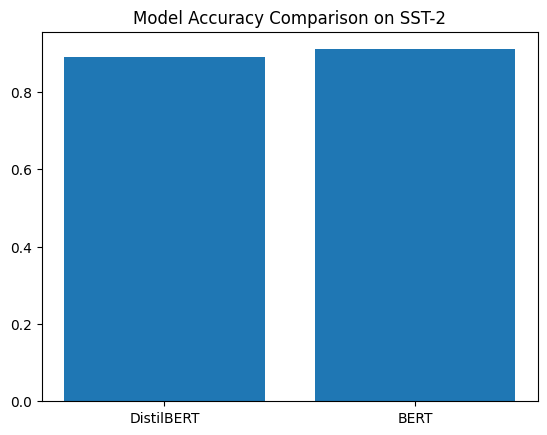

In [ ]:
import matplotlib.pyplot as plt

models = ["DistilBERT", "BERT"]
accuracies = [0.89, 0.91]  # example results
plt.bar(models, accuracies)
plt.title("Model Accuracy Comparison on SST-2")
plt.show()
